# Test increased input size

So far we've been stuck with input size 1024 because of memory problems.

Let's try to increase this by shrinking other parts of the model, using multiple GPUs, or using a longer version of the model.

### Longformer
Let's use the `Longformer` model defined in prior work, which uses local self-attention rather than global attention to reduce memory/training time.

Details [here](https://huggingface.co/transformers/model_doc/longformer.html).

In [1]:
from transformers import LongformerConfig, LongformerModel
config = LongformerConfig()
cache_dir = '../../data/longformer_cache/'
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

In [2]:
# save config for later?
model.config.to_json_file('../../data/longformer_cache/longformer_config.json')

In [3]:
from transformers import LongformerTokenizer, BartTokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', cache_dir=cache_dir)
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base', cache_dir='../../data/nyt_comments/model_cache/')
test_input_str = ['this is an input sentence', 'this is another input sentence']
test_input_ids = tokenizer.encode_plus(test_input_str[0])
print(test_input_ids)

{'input_ids': [0, 9226, 16, 41, 8135, 3645, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [3]:
## test max document length
import numpy as np
np.random.seed(123)
test_vocab = ['testing', 'words', 'sentence', 'language']
max_doc_length = 4096
test_input_str = ' '.join(np.random.choice(test_vocab, max_doc_length, replace=True))
test_input_tokens = tokenizer.encode_plus(test_input_str, truncation=True)
import torch
device_name = 'cuda:2'
model.to(device_name)
with torch.no_grad():
    test_input_ids = torch.LongTensor(test_input_tokens['input_ids']).reshape(1,-1)
    test_attention = torch.LongTensor(test_input_tokens['attention_mask']).reshape(1,-1)
    test_input_ids = test_input_ids.to(device_name)
    test_attention = test_attention.to(device_name)
    test_output = model(test_input_ids, test_attention)
    test_input_ids = test_input_ids.to('cpu')
    test_attention = test_attention.to('cpu')

In [4]:
print(test_output)

(tensor([[[-0.0527, -0.0315,  0.0286,  ..., -0.0564, -0.0239, -0.0570],
         [ 0.0341, -0.0290,  0.1896,  ..., -0.5842,  0.0429, -0.0135],
         [ 0.1834, -0.1210,  0.2500,  ..., -0.6635,  0.1980,  0.0649],
         ...,
         [-0.0481, -0.0921,  0.0864,  ..., -0.3947, -0.0060, -0.0552],
         [-0.0623, -0.0581,  0.0635,  ..., -0.4156, -0.0499, -0.0616],
         [-0.1087, -0.1674,  0.1134,  ..., -0.2352,  0.0707, -0.0627]]],
       device='cuda:2'), tensor([[ 1.9369e-01, -2.9230e-01,  5.1652e-02, -1.8974e-02,  3.5887e-01,
         -1.5266e-01, -5.1965e-01, -3.5222e-01, -9.4029e-02, -3.4605e-01,
         -4.7307e-01, -1.3086e-01,  2.2708e-01, -3.5769e-01,  4.5912e-02,
         -2.0275e-01, -3.2902e-01, -1.1249e-01, -1.3565e-01, -8.9653e-02,
         -4.8179e-02,  2.1219e-03, -2.2777e-01,  5.8795e-02, -5.1465e-01,
         -2.5448e-02, -1.5650e-01, -3.0164e-01,  2.6552e-01,  2.6359e-01,
         -4.8347e-02, -4.6063e-02, -2.9614e-01,  2.9422e-02,  4.3749e-02,
          2.71

In [5]:
test_output[0].shape

torch.Size([1, 4096, 768])

It seems like this worked! Can this handle the news articles in our data?

In [4]:
## load sample data
import pandas as pd
NYT_article_data = pd.read_csv('../../data/nyt_comments/NYT_question_data_train_data.csv', sep=',', index_col=False)
display(NYT_article_data.head())

,source_text,target_text,article_id
0,WASHINGTON -- President Trump's advisers have ...,Where is our supine U. S. Congress?,5ad09d04068401528a2a8848
1,A federal judge in Manhattan indicated on Mond...,would that apply to me if I were in those circ...,5ad49614068401528a2a8e81
2,"President Trump recently tweeted, “ The United...","@ Sarah : I ask, in all sincerity, what good t...",5add197f068401528a2aa147
3,I came to America from India at age 23. That w...,Why aren't Indian citizens and other immigrant...,5ad75687068401528a2a95e6
4,No president in my lifetime has made me think ...,But what about at home?,5ac4059c068401528a2a1c89


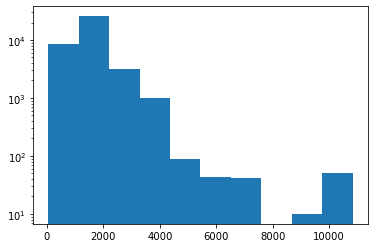

In [15]:
NYT_article_data = NYT_article_data.assign(**{
    'source_text_len' : NYT_article_data.loc[:, 'source_text'].apply(lambda x: len(tokenizer.tokenize(x)))
})
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(NYT_article_data.loc[:, 'source_text_len'].values)
plt.yscale('log')
plt.show()

In [19]:
max_source_length = 4096
print(f'{NYT_article_data[NYT_article_data.loc[:, "source_text_len"]>=max_source_length].drop_duplicates("article_id").shape[0]} / {NYT_article_data.loc[:, "article_id"].nunique()} articles above max source length')
print(f'{NYT_article_data[NYT_article_data.loc[:, "source_text_len"]>=max_source_length].shape[0]} / {NYT_article_data.shape[0]} questions with articles above max source length')

9 / 747 articles above max source length
355 / 38445 questions with articles above max source length


Great! Relatively few articles that are too long to encode.

Let's test generation too just for sanity.

In [6]:
sample_article_text = NYT_article_data.loc[:, 'source_text'].iloc[0]
print(sample_article_text)

WASHINGTON -- President Trump's advisers have concluded that a wide-ranging corruption investigation into his personal lawyer poses a greater and more imminent threat to the president than even the special counsel's investigation, according to several people close to Mr. Trump. As his lawyers went to court in New York on Friday to try to block prosecutors from reading files that were seized from the personal lawyer, Michael D. Cohen, this week, Mr. Trump found himself increasingly isolated in mounting a response. He continued to struggle to hire a new criminal lawyer, and some of his own aides were reluctant to advise him about a response for fear of being dragged into a criminal investigation themselves. The raids on Mr. Cohen came as part of a monthslong federal investigation based in New York, court records show, and were sweeping in their breadth. In addition to searching his home, office and hotel room, F. B. I. agents seized material from Mr. Cohen's cellphones, tablet, laptop an

In [19]:
test_input_tokens = tokenizer.encode_plus(sample_article_text)
# print(len(sample_article_ids['input_ids']))
import torch
device_name = 'cuda:2'
model.to(device_name)
with torch.no_grad():
    test_input_ids = torch.LongTensor(test_input_tokens['input_ids']).reshape(1,-1)
    test_attention = torch.LongTensor(test_input_tokens['attention_mask']).reshape(1,-1)
    test_input_ids = test_input_ids.to(device_name)
    test_attention = test_attention.to(device_name)
    test_output = model.generate(test_input_ids)
    test_input_ids = test_input_ids.to('cpu')
    test_attention = test_attention.to('cpu')

In [25]:
print(test_output.shape)
print(tokenizer.decode(test_input_ids[0, :]))
print(tokenizer.decode(test_output[0, :]))

torch.Size([1, 1516])
<s>WASHINGTON -- President Trump's advisers have concluded that a wide-ranging corruption investigation into his personal lawyer poses a greater and more imminent threat to the president than even the special counsel's investigation, according to several people close to Mr. Trump. As his lawyers went to court in New York on Friday to try to block prosecutors from reading files that were seized from the personal lawyer, Michael D. Cohen, this week, Mr. Trump found himself increasingly isolated in mounting a response. He continued to struggle to hire a new criminal lawyer, and some of his own aides were reluctant to advise him about a response for fear of being dragged into a criminal investigation themselves. The raids on Mr. Cohen came as part of a monthslong federal investigation based in New York, court records show, and were sweeping in their breadth. In addition to searching his home, office and hotel room, F. B. I. agents seized material from Mr. Cohen's cell

OK! It seems that the Longformer doesn't actually generate text, it just copies it.

Let's try to use the model but with the `BART` base, which is a known encoder/decoder.

In [1]:
from transformers import AutoModelForSeq2SeqLM
longformer_enc_dec_model = AutoModelForSeq2SeqLM.from_pretrained('allenai/led-base-16384', cache_dir='../../data/longformer_cache/')

In [26]:
longformer_enc_dec_model.config.max_length = 512

In [3]:
from transformers import AutoTokenizer
longformer_enc_dec_tokenizer = AutoTokenizer.from_pretrained('allenai/led-base-16384', cache_dir='../../data/longformer_cache/')

In [27]:
sample_article_text = NYT_article_data.loc[:, 'source_text'].iloc[0]
print(sample_article_text)
test_input_tokens = longformer_enc_dec_tokenizer.encode_plus(sample_article_text)
# print(len(sample_article_ids['input_ids']))
import torch
device_name = 'cuda:2'
longformer_enc_dec_model.to(device_name)
with torch.no_grad():
    test_input_ids = torch.LongTensor(test_input_tokens['input_ids']).reshape(1,-1)
    test_attention = torch.LongTensor(test_input_tokens['attention_mask']).reshape(1,-1)
    test_input_ids = test_input_ids.to(device_name)
    test_attention = test_attention.to(device_name)
    test_output = longformer_enc_dec_model.generate(test_input_ids, num_beams=8, temperature=1.0)
    test_input_ids = test_input_ids.to('cpu')
    test_attention = test_attention.to('cpu')
    test_output = test_output.to('cpu')
longformer_enc_dec_model.to('cpu')

WASHINGTON -- President Trump's advisers have concluded that a wide-ranging corruption investigation into his personal lawyer poses a greater and more imminent threat to the president than even the special counsel's investigation, according to several people close to Mr. Trump. As his lawyers went to court in New York on Friday to try to block prosecutors from reading files that were seized from the personal lawyer, Michael D. Cohen, this week, Mr. Trump found himself increasingly isolated in mounting a response. He continued to struggle to hire a new criminal lawyer, and some of his own aides were reluctant to advise him about a response for fear of being dragged into a criminal investigation themselves. The raids on Mr. Cohen came as part of a monthslong federal investigation based in New York, court records show, and were sweeping in their breadth. In addition to searching his home, office and hotel room, F. B. I. agents seized material from Mr. Cohen's cellphones, tablet, laptop an

LEDForConditionalGeneration(
  (led): LEDModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): LEDEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): LEDLearnedPositionalEmbedding(16384, 768, padding_idx=1)
      (layers): ModuleList(
        (0): LEDEncoderLayer(
          (self_attn): LEDEncoderAttention(
            (longformer_self_attn): LEDEncoderSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Linear(in_features=768, out_features=768, bias=True)
        

In [28]:
test_input_ids.shape

torch.Size([1, 1516])

In [29]:
print(longformer_enc_dec_tokenizer.decode(torch.LongTensor(test_output[0])))

</s><s>WASHINGTON -- President Trump's advisers have called the raid of his offices and hotel room an overreach of the law. Prosecutors said on Friday that they had used a search warrant, rather than a subpoena, because they had evidence that Mr. Cohen's files might be permanently deleted -- by whom, the documents did not say. Many details in the documents were redacted, but prosecutors said they had found evidence of fraud and a" lack of truthfulness" on his part. Mr. Cohen wants his lawyers to be able to review the files and withhold privileged material before prosecutors can see them. As an alternative, he asked that an independent lawyer be allowed to review the files first. A judge scheduled a follow-up hearing for Monday and ordered Mr. Cohen to attend. The judge, Kimba M. Wood, was upset that he was not in court Friday. Federal agents seized documents that dated back years, some of which are related to payments to two women who have said they had affairs with Mr. Trump. Other do

OK! We see that the model generally copies the input data without really "processing" it. This means that there's lots of room for improvement with training!

### Train with LongFormer
Next, let's adapt the model that we built from scratch [here](reader_aware_question_generation_tests.ipynb) and change it to work with the `LongFormer` model.

In [20]:
# set 1 GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [21]:
## arguments
from dataclasses import dataclass, field
from typing import Optional
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    freeze_encoder: bool = field(default=False, metadata={"help": "Whether tp freeze the encoder."})
    freeze_embeds: bool = field(default=False, metadata={"help": "Whether  to freeze the embeddings."})
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """
    data_dir: str = field(
        metadata={"help": "The input data dir. Should contain the .tsv files (or other data files) for the task."}
    )
    task: Optional[str] = field(
        default="summarization",
        metadata={"help": "Task name, summarization (or summarization_{dataset} for pegasus) or translation"},
    )
    max_source_length: Optional[int] = field(
        default=1024,
        metadata={
            "help": "The maximum total input sequence length after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded."
        },
    )
    max_target_length: Optional[int] = field(
        default=128,
        metadata={
            "help": "The maximum total sequence length for target text after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded."
        },
    )
    val_max_target_length: Optional[int] = field(
        default=142,
        metadata={
            "help": "The maximum total sequence length for validation target text after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded. "
            "This argument is also used to override the ``max_length`` param of ``model.generate``, which is used "
            "during ``evaluate`` and ``predict``."
        },
    )
    test_max_target_length: Optional[int] = field(
        default=142,
        metadata={
            "help": "The maximum total sequence length for test target text after tokenization. Sequences longer "
            "than this will be truncated, sequences shorter will be padded."
        },
    )
    n_train: Optional[int] = field(default=-1, metadata={"help": "# training examples. -1 means use all."})
    n_val: Optional[int] = field(default=-1, metadata={"help": "# validation examples. -1 means use all."})
    n_test: Optional[int] = field(default=-1, metadata={"help": "# test examples. -1 means use all."})
    src_lang: Optional[str] = field(default=None, metadata={"help": "Source language id for translation."})
    tgt_lang: Optional[str] = field(default=None, metadata={"help": "Target language id for translation."})
    eval_beams: Optional[int] = field(default=None, metadata={"help": "# num_beams to use for evaluation."})
    ignore_pad_token_for_loss: bool = field(
        default=True,
        metadata={"help": "If only pad tokens should be ignored. This assumes that `config.pad_token_id` is defined."},
    )
        
from transformers.training_args import TrainingArguments
@dataclass
class Seq2SeqTrainingArguments(TrainingArguments):
    """
    sortish_sampler (:obj:`bool`, `optional`, defaults to :obj:`False`):
        Whether to use a `sortish sampler` or not. Only possible if the underlying datasets are `Seq2SeqDataset` for
        now but will become generally available in the near future.
        It sorts the inputs according to lengths in order to minimize the padding size, with a bit of randomness for
        the training set.
    predict_with_generate (:obj:`bool`, `optional`, defaults to :obj:`False`):
        Whether to use generate to calculate generative metrics (ROUGE, BLEU).
    """

    sortish_sampler: bool = field(default=False, metadata={"help": "Whether to use SortishSampler or not."})
    predict_with_generate: bool = field(
        default=False, metadata={"help": "Whether to use generate to calculate generative metrics (ROUGE, BLEU)."}
    )
## training
from transformers import Trainer, PreTrainedModel
from torch import nn
from typing import Union, Any
from transformers.configuration_utils import PretrainedConfig
class FSMTConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a :class:`~transformers.FSMTModel`. It is used to
    instantiate a FSMT model according to the specified arguments, defining the model architecture.
    Configuration objects inherit from :class:`~transformers.PretrainedConfig` and can be used to control the model
    outputs. Read the documentation from :class:`~transformers.PretrainedConfig` for more information.
    Args:
        langs (:obj:`List[str]`):
            A list with source language and target_language (e.g., ['en', 'ru']).
        src_vocab_size (:obj:`int`):
            Vocabulary size of the encoder. Defines the number of different tokens that can be represented by the
            :obj:`inputs_ids` passed to the forward method in the encoder.
        tgt_vocab_size (:obj:`int`):
            Vocabulary size of the decoder. Defines the number of different tokens that can be represented by the
            :obj:`inputs_ids` passed to the forward method in the decoder.
        d_model (:obj:`int`, `optional`, defaults to 1024):
            Dimensionality of the layers and the pooler layer.
        encoder_layers (:obj:`int`, `optional`, defaults to 12):
            Number of encoder layers.
        decoder_layers (:obj:`int`, `optional`, defaults to 12):
            Number of decoder layers.
        encoder_attention_heads (:obj:`int`, `optional`, defaults to 16):
            Number of attention heads for each attention layer in the Transformer encoder.
        decoder_attention_heads (:obj:`int`, `optional`, defaults to 16):
            Number of attention heads for each attention layer in the Transformer decoder.
        decoder_ffn_dim (:obj:`int`, `optional`, defaults to 4096):
            Dimensionality of the "intermediate" (often named feed-forward) layer in decoder.
        encoder_ffn_dim (:obj:`int`, `optional`, defaults to 4096):
            Dimensionality of the "intermediate" (often named feed-forward) layer in decoder.
        activation_function (:obj:`str` or :obj:`Callable`, `optional`, defaults to :obj:`"relu"`):
            The non-linear activation function (function or string) in the encoder and pooler. If string,
            :obj:`"gelu"`, :obj:`"relu"`, :obj:`"silu"` and :obj:`"gelu_new"` are supported.
        dropout (:obj:`float`, `optional`, defaults to 0.1):
            The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
        attention_dropout (:obj:`float`, `optional`, defaults to 0.0):
            The dropout ratio for the attention probabilities.
        activation_dropout (:obj:`float`, `optional`, defaults to 0.0):
            The dropout ratio for activations inside the fully connected layer.
        max_position_embeddings (:obj:`int`, `optional`, defaults to 1024):
            The maximum sequence length that this model might ever be used with. Typically set this to something large
            just in case (e.g., 512 or 1024 or 2048).
        init_std (:obj:`float`, `optional`, defaults to 0.02):
            The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
        scale_embedding (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Scale embeddings by diving by sqrt(d_model).
        bos_token_id (:obj:`int`, `optional`, defaults to 0)
            Beginning of stream token id.
        pad_token_id (:obj:`int`, `optional`, defaults to 1)
            Padding token id.
        eos_token_id (:obj:`int`, `optional`, defaults to 2)
            End of stream token id.
        decoder_start_token_id (:obj:`int`, `optional`):
            This model starts decoding with :obj:`eos_token_id`
        encoder_layerdrop: (:obj:`float`, `optional`, defaults to 0.0):
            Google "layerdrop arxiv", as its not explainable in one line.
        decoder_layerdrop: (:obj:`float`, `optional`, defaults to 0.0):
            Google "layerdrop arxiv", as its not explainable in one line.
        is_encoder_decoder (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether this is an encoder/decoder model.
        tie_word_embeddings (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Whether to tie input and output embeddings.
        num_beams (:obj:`int`, `optional`, defaults to 5)
            Number of beams for beam search that will be used by default in the :obj:`generate` method of the model. 1
            means no beam search.
        length_penalty (:obj:`float`, `optional`, defaults to 1)
            Exponential penalty to the length that will be used by default in the :obj:`generate` method of the model.
        early_stopping (:obj:`bool`, `optional`, defaults to :obj:`False`)
            Flag that will be used by default in the :obj:`generate` method of the model. Whether to stop the beam
            search when at least ``num_beams`` sentences are finished per batch or not.
        use_cache (:obj:`bool`, `optional`, defaults to :obj:`True`):
            Whether or not the model should return the last key/values attentions (not used by all models).
        Examples::
            >>> from transformers import FSMTConfig, FSMTModel
            >>> config = FSMTConfig.from_pretrained('facebook/wmt19-en-ru')
            >>> model = FSMTModel(config)
    """
    model_type = "fsmt"

    # update the defaults from config file
    def __init__(
        self,
        langs=["en", "de"],
        src_vocab_size=42024,
        tgt_vocab_size=42024,
        activation_function="relu",
        d_model=1024,
        max_length=200,
        max_position_embeddings=1024,
        encoder_ffn_dim=4096,
        encoder_layers=12,
        encoder_attention_heads=16,
        encoder_layerdrop=0.0,
        decoder_ffn_dim=4096,
        decoder_layers=12,
        decoder_attention_heads=16,
        decoder_layerdrop=0.0,
        attention_dropout=0.0,
        dropout=0.1,
        activation_dropout=0.0,
        init_std=0.02,
        decoder_start_token_id=2,
        is_encoder_decoder=True,
        scale_embedding=True,
        tie_word_embeddings=False,
        num_beams=5,
        length_penalty=1.0,
        early_stopping=False,
        use_cache=True,
        pad_token_id=1,
        bos_token_id=0,
        eos_token_id=2,
        **common_kwargs
    ):
        if "hidden_size" in common_kwargs:
            raise ValueError("hidden size is called d_model")
        super().__init__(
            pad_token_id=pad_token_id,
            bos_token_id=bos_token_id,
            eos_token_id=eos_token_id,
            decoder_start_token_id=decoder_start_token_id,
            is_encoder_decoder=is_encoder_decoder,
            tie_word_embeddings=tie_word_embeddings,
            **common_kwargs,
        )
        self.langs = langs
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.d_model = d_model  # encoder_embed_dim and decoder_embed_dim
        self.max_length = max_length

        self.encoder_ffn_dim = encoder_ffn_dim
        self.encoder_layers = self.num_hidden_layers = encoder_layers
        self.encoder_attention_heads = encoder_attention_heads
        self.encoder_layerdrop = encoder_layerdrop
        self.decoder_layerdrop = decoder_layerdrop
        self.decoder_ffn_dim = decoder_ffn_dim
        self.decoder_layers = decoder_layers
        self.decoder_attention_heads = decoder_attention_heads
        self.max_position_embeddings = max_position_embeddings
        self.init_std = init_std  # Normal(0, this parameter)
        self.activation_function = activation_function

        self.num_beams = num_beams
        self.length_penalty = length_penalty
        self.early_stopping = early_stopping

        self.decoder = DecoderConfig(vocab_size=tgt_vocab_size, bos_token_id=eos_token_id)

        self.scale_embedding = scale_embedding  # scale factor will be sqrt(d_model) if True

        # 3 Types of Dropout
        self.attention_dropout = attention_dropout
        self.activation_dropout = activation_dropout
        self.dropout = dropout

        self.use_cache = use_cache

    @property
    def num_attention_heads(self) -> int:
        return self.encoder_attention_heads

    @property
    def hidden_size(self) -> int:
        return self.d_model

    def to_dict(self):
        """
        Serializes this instance to a Python dictionary. Override the default `to_dict()` from `PretrainedConfig`.
        Returns:
            :obj:`Dict[str, any]`: Dictionary of all the attributes that make up this configuration instance,
        """
        output = copy.deepcopy(self.__dict__)
        output["decoder"] = self.decoder.to_dict()
        output["model_type"] = self.__class__.model_type
        return output
import torch
from typing import Callable, Dict, Tuple, List
from enum import Enum
from transformers.file_utils import is_torch_tpu_available
from torch.utils.data import DistributedSampler, RandomSampler
from transformers.optimization import Adafactor, get_constant_schedule, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup, get_linear_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup
class ParallelMode(Enum):
    NOT_PARALLEL = "not_parallel"
    NOT_DISTRIBUTED = "not_distributed"
    DISTRIBUTED = "distributed"
    TPU = "tpu"
arg_to_scheduler = {
    "linear": get_linear_schedule_with_warmup,
    "cosine": get_cosine_schedule_with_warmup,
    "cosine_w_restarts": get_cosine_with_hard_restarts_schedule_with_warmup,
    "polynomial": get_polynomial_decay_schedule_with_warmup,
    "constant": get_constant_schedule,
    "constant_w_warmup": get_constant_schedule_with_warmup,
}
class Seq2SeqTrainer(Trainer):
    def __init__(self, config=None, data_args=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        if config is None:
            assert isinstance(
                self.model, PreTrainedModel
            ), f"If no `config` is passed the model to be trained has to be of type `PreTrainedModel`, but is {self.model.__class__}"
            self.config = self._actual_model(self.model).config
        else:
            self.config = config

        self.data_args = data_args
        self.vocab_size = self.config.tgt_vocab_size if isinstance(self.config, FSMTConfig) else self.config.vocab_size

        if self.args.label_smoothing != 0 or (self.data_args is not None and self.data_args.ignore_pad_token_for_loss):
            assert (
                self.config.pad_token_id is not None
            ), "Make sure that `config.pad_token_id` is correcly defined when ignoring `pad_token` for loss calculation or doing label smoothing."

        if self.config.pad_token_id is None and self.config.eos_token_id is not None:
            logger.warn(
                f"The `config.pad_token_id` is `None`. Using `config.eos_token_id` = {self.config.eos_token_id} for padding.."
            )

        if self.args.label_smoothing == 0:
            self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=self.config.pad_token_id)
        else:
            # dynamically import label_smoothed_nll_loss
            from utils import label_smoothed_nll_loss

            self.loss_fn = label_smoothed_nll_loss

    def create_optimizer_and_scheduler(self, num_training_steps: int):
        """
        Setup the optimizer and the learning rate scheduler.
        We provide a reasonable default that works well. If you want to use something else, you can pass a tuple in the
        Trainer's init through :obj:`optimizers`, or subclass and override this method in a subclass.
        """
        if self.optimizer is None:
            no_decay = ["bias", "LayerNorm.weight"]
            optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                    "weight_decay": self.args.weight_decay,
                },
                {
                    "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                    "weight_decay": 0.0,
                },
            ]
            optimizer_cls = Adafactor if self.args.adafactor else AdamW
            if self.args.adafactor:
                optimizer_cls = Adafactor
                optimizer_kwargs = {"scale_parameter": False, "relative_step": False}
            else:
                optimizer_cls = AdamW
                optimizer_kwargs = {
                    "betas": (self.args.adam_beta1, self.args.adam_beta2),
                    "eps": self.args.adam_epsilon,
                }
            optimizer_kwargs["lr"] = self.args.learning_rate
            if self.sharded_dpp:
                self.optimizer = OSS(
                    params=optimizer_grouped_parameters,
                    optim=optimizer_cls,
                    **optimizer_kwargs,
                )
            else:
                self.optimizer = optimizer_cls(optimizer_grouped_parameters, **optimizer_kwargs)

        if self.lr_scheduler is None:
            self.lr_scheduler = self._get_lr_scheduler(num_training_steps)
        else:  # ignoring --lr_scheduler
            logger.warn("scheduler is passed to `Seq2SeqTrainer`, `--lr_scheduler` arg is ignored.")

    def _get_lr_scheduler(self, num_training_steps):
        schedule_func = arg_to_scheduler[self.args.lr_scheduler]
        if self.args.lr_scheduler == "constant":
            scheduler = schedule_func(self.optimizer)
        elif self.args.lr_scheduler == "constant_w_warmup":
            scheduler = schedule_func(self.optimizer, num_warmup_steps=self.args.warmup_steps)
        else:
            scheduler = schedule_func(
                self.optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=num_training_steps
            )
        return scheduler

    def _get_train_sampler(self) -> Optional[torch.utils.data.sampler.Sampler]:
        if isinstance(self.train_dataset, torch.utils.data.IterableDataset):
            return None
        elif is_torch_tpu_available():
            return get_tpu_sampler(self.train_dataset)
        else:
            if self.args.sortish_sampler:
                self.train_dataset.make_sortish_sampler(
                    self.args.per_device_train_batch_size,
                    distributed=(self.args.parallel_mode == ParallelMode.DISTRIBUTED),
                )

            return (
                RandomSampler(self.train_dataset)
                if self.args.local_rank == -1
                else DistributedSampler(self.train_dataset)
            )

    def _compute_loss(self, model, inputs, labels):
        if self.args.label_smoothing == 0:
            if self.data_args is not None and self.data_args.ignore_pad_token_for_loss:
                # force training to ignore pad token
                logits = model(**inputs, use_cache=False)[0]
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            else:
                # compute usual loss via models
                loss, logits = model(**inputs, labels=labels, use_cache=False)[:2]
        else:
            # compute label smoothed loss
            logits = model(**inputs, use_cache=False)[0]
            lprobs = torch.nn.functional.log_softmax(logits, dim=-1)
            loss, _ = self.loss_fn(lprobs, labels, self.args.label_smoothing, ignore_index=self.config.pad_token_id)
        return loss, logits

    def compute_loss(self, model, inputs):
        labels = inputs.pop("labels")
        loss, _ = self._compute_loss(model, inputs, labels)
        return loss

    def prediction_step(
        self,
        model: nn.Module,
        inputs: Dict[str, Union[torch.Tensor, Any]],
        prediction_loss_only: bool,
        ignore_keys: Optional[List[str]] = None,
    ) -> Tuple[Optional[float], Optional[torch.Tensor], Optional[torch.Tensor]]:
        """
        Perform an evaluation step on :obj:`model` using obj:`inputs`.
        Subclass and override to inject custom behavior.
        Args:
            model (:obj:`nn.Module`):
                The model to evaluate.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.
            prediction_loss_only (:obj:`bool`):
                Whether or not to return the loss only.
        Return:
            Tuple[Optional[float], Optional[torch.Tensor], Optional[torch.Tensor]]:
            A tuple with the loss, logits and labels (each being optional).
        """
        inputs = self._prepare_inputs(inputs)

        gen_kwargs = {
            "max_length": self.data_args.val_max_target_length
            if self.data_args is not None
            else self.config.max_length,
        }

        if self.args.predict_with_generate and not self.args.prediction_loss_only:
            generated_tokens = self.model.generate(
                inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                **gen_kwargs,
            )
            # in case the batch is shorter than max length, the output should be padded
            if generated_tokens.shape[-1] < gen_kwargs["max_length"]:
                generated_tokens = self._pad_tensors_to_max_len(generated_tokens, gen_kwargs["max_length"])

        labels = inputs.pop("labels")
        with torch.no_grad():
            # compute loss on predict data
            loss, logits = self._compute_loss(model, inputs, labels)

        loss = loss.mean().detach()
        if self.args.prediction_loss_only:
            return (loss, None, None)

        logits = generated_tokens if self.args.predict_with_generate else logits

        if labels.shape[-1] < gen_kwargs["max_length"]:
            labels = self._pad_tensors_to_max_len(labels, gen_kwargs["max_length"])

        return (loss, logits, labels)

    def _pad_tensors_to_max_len(self, tensor, max_length):
        # If PAD token is not defined at least EOS token has to be defined
        pad_token_id = self.config.pad_token_id if self.config.pad_token_id is not None else self.config.eos_token_id

        if pad_token_id is None:
            raise ValueError(
                f"Make sure that either `config.pad_token_id` or `config.eos_token_id` is defined if tensor has to be padded to `max_length`={max_length}"
            )

        padded_tensor = pad_token_id * torch.ones(
            (tensor.shape[0], max_length), dtype=tensor.dtype, device=tensor.device
        )
        padded_tensor[:, : tensor.shape[-1]] = tensor
        return padded_tensor
def convert_ids_to_clean_str(token_ids, tokenizer):
    tokens = tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=True)
    token_str = tokenizer.convert_tokens_to_string(tokens)
    return token_str
from transformers import BartTokenizer
class Seq2SeqDataCollator:
    def __init__(self, tokenizer, data_args, tpu_num_cores=None):
        self.tokenizer = tokenizer
        self.pad_token_id = tokenizer.pad_token_id
        assert (
            self.pad_token_id is not None
        ), f"pad_token_id is not defined for ({self.tokenizer.__class__.__name__}), it must be defined."
        self.data_args = data_args
        self.tpu_num_cores = tpu_num_cores
        self.dataset_kwargs = {"add_prefix_space": True} if isinstance(tokenizer, BartTokenizer) else {}
        if data_args.src_lang is not None:
            self.dataset_kwargs["src_lang"] = data_args.src_lang
        if data_args.tgt_lang is not None:
            self.dataset_kwargs["tgt_lang"] = data_args.tgt_lang

    def __call__(self, batch) -> Dict[str, torch.Tensor]:
        if hasattr(self.tokenizer, "prepare_seq2seq_batch"):
            batch = self._encode(batch)
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
        else:
            input_ids = torch.stack([x["input_ids"] for x in batch])
            attention_mask = torch.stack([x["attention_mask"] for x in batch])
            labels = torch.stack([x["labels"] for x in batch])

            labels = trim_batch(labels, self.pad_token_id)
            input_ids, attention_mask = trim_batch(input_ids, self.pad_token_id, attention_mask=attention_mask)

        batch = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }
        return batch

    def _shift_right_t5(self, input_ids):
        # shift inputs to the right
        shifted_input_ids = input_ids.new_zeros(input_ids.shape)
        shifted_input_ids[..., 1:] = input_ids[..., :-1].clone()
        shifted_input_ids[..., 0] = self.pad_token_id
        return shifted_input_ids

    def _encode(self, batch) -> Dict[str, torch.Tensor]:
        batch_encoding = self.tokenizer.prepare_seq2seq_batch(
#             [x["source_text"] for x in batch],
#             tgt_texts=[x["target_text"] for x in batch],
            [convert_ids_to_clean_str(x['source_ids'], self.tokenizer) for x in batch],
            tgt_texts=[convert_ids_to_clean_str(x['target_ids'], self.tokenizer) for x in batch],
            max_length=self.data_args.max_source_length,
            max_target_length=self.data_args.max_target_length,
            padding="max_length" if self.tpu_num_cores is not None else "longest",  # TPU hack
            return_tensors="pt",
            **self.dataset_kwargs,
        )
        return batch_encoding.data
## evaluation
from transformers import PreTrainedTokenizer, EvalPrediction
from sacrebleu import corpus_bleu
import numpy as np
def calculate_bleu(output_lns, refs_lns, **kwargs) -> dict:
    """Uses sacrebleu's corpus_bleu implementation."""
    return {"bleu": round(corpus_bleu(output_lns, [refs_lns], **kwargs).score, 4)}
def build_compute_metrics_fn(task_name: str, tokenizer: PreTrainedTokenizer) -> Callable[[EvalPrediction], Dict]:
    def non_pad_len(tokens: np.ndarray) -> int:
        return np.count_nonzero(tokens != tokenizer.pad_token_id)

    def decode_pred(pred: EvalPrediction) -> Tuple[List[str], List[str]]:
        pred_str = tokenizer.batch_decode(pred.predictions, skip_special_tokens=True)
        label_str = tokenizer.batch_decode(pred.label_ids, skip_special_tokens=True)
        pred_str = lmap(str.strip, pred_str)
        label_str = lmap(str.strip, label_str)
        return pred_str, label_str

    def summarization_metrics(pred: EvalPrediction) -> Dict:
        pred_str, label_str = decode_pred(pred)
        rouge: Dict = calculate_rouge(pred_str, label_str)
        summ_len = np.round(np.mean(lmap(non_pad_len, pred.predictions)), 1)
        rouge.update({"gen_len": summ_len})
        return rouge

    def translation_metrics(pred: EvalPrediction) -> Dict:
        pred_str, label_str = decode_pred(pred)
        bleu: Dict = calculate_bleu(pred_str, label_str)
        gen_len = np.round(np.mean(lmap(non_pad_len, pred.predictions)), 1)
        bleu.update({"gen_len": gen_len})
        return bleu

    compute_metrics_fn = summarization_metrics if "summarization" in task_name else translation_metrics
    return compute_metrics_fn

In [ ]:
import transformers
from transformers import HfArgumentParser
# parser = HfArgumentParser((ModelArguments, DataTrainingArguments, Seq2SeqTrainingArguments))
# model_args, data_args, training_args = parser.parse_args_into_dataclasses()
# NYT author data
data_args = DataTrainingArguments('../../data/nyt_comments/author_data_model/')
training_args = Seq2SeqTrainingArguments('../../data/nyt_comments/debug_model/')
# BART config
model_args = ModelArguments('../../data/nyt_comments/author_data_model/question_generation_model/config.json')
# LongFormer config

# CNN data
# data_args = DataTrainingArguments('../../data/CNN_articles/cnn/')
# training_args = Seq2SeqTrainingArguments('../../data/CNN_articles/cnn/debug_model/')
# model_args = ModelArguments('../../data/CNN_articles/cnn/question_generation_model/config.json')
## add extra args
training_args.local_rank = -1
training_args.seed = 123
# training_args.model_name_or_path = 'facebook/bart-base'
# NYT author data
training_args.tokenizer_name = '../../data/nyt_comments/author_data_model/BART_tokenizer.pt'
training_args.cache_dir = '../../data/nyt_comments/model_cache/'
# CNN data
# training_args.tokenizer_name = '../../data/CNN_articles/cnn/BART_tokenizer.pt'
# training_args.cache_dir = '../../data/CNN_articles/cnn/model_cache/'
training_args.label_smoothing = 0.
training_args.tpu_num_cores = 0.
training_args.parallel_mode = 'not_parallel'
training_args.adafactor = True
training_args.lr_scheduler = 'linear'
training_args.per_device_train_batch_size = 2
training_args.per_device_eval_batch_size = 2
training_args.do_eval = True
training_args.evaluate_during_training = True
training_args.evaluation_strategy = 'steps'
# training_args.eval_steps = 100
# NYT comments => less data means more training
training_args.num_train_epochs = 6
# CNN comments
# training_args.num_train_epochs = 3
training_args.save_total_limit = 2
data_args.max_source_length = 1024
data_args.max_target_length = 64
data_args.task = 'summarization'

In [ ]:
## train
import logging
from transformers import set_seed, AutoConfig, AutoModelForSeq2SeqLM
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN,
    )
logger = logging.getLogger(__name__)
logger.warning(
    "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
    training_args.local_rank,
    training_args.device,
    training_args.n_gpu,
    bool(training_args.parallel_mode == ParallelMode.DISTRIBUTED),
    training_args.fp16,
)
transformers.utils.logging.set_verbosity_info()
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.info("Training/evaluation parameters %s", training_args)
set_seed(training_args.seed)
# author-type data
model_path = '../../data/nyt_comments/debug_model/question_generation_model/'
# CNN baseline data
# model_path = '../../data/CNN_articles/cnn/debug_model/'
config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
    )
extra_model_params = ("encoder_layerdrop", "decoder_layerdrop", "dropout", "attention_dropout")
for p in extra_model_params:
    if getattr(training_args, p, None):
        assert hasattr(config, p), f"({config.__class__.__name__}) doesn't have a `{p}` attribute"
        setattr(config, p, getattr(training_args, p))
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_path,
    from_tf=".ckpt" in model_args.model_name_or_path,
    config=config,
    cache_dir=model_args.cache_dir,
)

import torch
# author-type data
tokenizer = torch.load('../../data/nyt_comments/author_data_model/BART_tokenizer.pt')
## author-type data: full
train_dataset = torch.load('../../data/nyt_comments/author_data_model/author_type_NYT_question_data_train_data.pt')
eval_dataset = torch.load('../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data.pt')
## author-type data: mini
# train_dataset = torch.load('../../data/nyt_comments/debug_model/mini_data/author_type_NYT_question_data_train_data.pt')
# eval_dataset = torch.load('../../data/nyt_comments/debug_model/mini_data/author_type_NYT_question_data_val_data.pt')
# CNN baseline data
# tokenizer = torch.load('../../data/CNN_articles/cnn/BART_tokenizer.pt')
# train_dataset = torch.load('../../data/CNN_articles/cnn/article_question_generation_train_data.pt')
# eval_dataset = torch.load('../../data/CNN_articles/cnn/article_question_generation_val_data.pt')
compute_metrics_fn = build_compute_metrics_fn(data_args.task, tokenizer)
model.resize_token_embeddings(len(tokenizer))
train_dataset = train_dataset['train']
eval_dataset = eval_dataset['train']
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=Seq2SeqDataCollator(tokenizer, data_args, training_args.tpu_num_cores),
    compute_metrics=compute_metrics_fn,
    tokenizer=tokenizer,
)
trainer.sharded_dpp = False

logger.info("*** Train ***")

train_result = trainer.train(
    model_path=model_path,
)

In [ ]:
## test
import torch
from tqdm import tqdm
num_beams = 8
temperature = 1.0
pred_text = []
with torch.no_grad():
    for data_i in tqdm(eval_dataset):
    #     trainer.prediction_step(data_i, )
        source_i = data_i['source_ids'].to(model.device).reshape(1,-1)
        attention_i = data_i['attention_mask'].to(model.device).reshape(1,-1)
        pred_i = model.generate(input_ids=source_i, 
                                attention_mask=attention_i,
                                num_beams=num_beams, 
                                temperature=temperature)
        pred_i = pred_i.to('cpu')
        pred_text_i = tokenizer.decode(pred_i[0], skip_special_tokens=True)
        pred_text.append(pred_text_i)